In [1]:
    import numpy as np
import pandas as pd
import scipy as sc
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score
from sklearn import preprocessing

import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
from math import isnan

## Import the Dataset

In [4]:
pwd()

'/Users/javiermazonechevarria/Desktop/LSE/ST451 Bayesian Machine Learning/Computer Classes'

In [772]:
data1 = pd.read_csv('your_path/data/aug_train.csv')
print(data1.shape, data2.shape)
data1.head()

(19158, 14) (2129, 13)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [773]:
print("{} columns:".format(len(data1.columns)))
data1.dtypes

14 columns:


enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

As most variables are categorical, they'll have to be coded as categorical ordinal variables with numbers, or with one-hot-encoding in case they are not ordinal

In [774]:
for col in data1.columns:
    print(" {} - {} different values: {}".format(col, len(data1[col].unique()), data1[col].unique()))

 enrollee_id - 19158 different values: [ 8949 29725 11561 ... 24576  5756 23834]
 city - 123 different values: ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' '

### Variables Coding
- enrollee_id: We'll get rid of this one as it doesn't tell anything
- city: Could have predictive power, but we would have to do one-hot-encoding as the city number is arbitrary and not ordinal. That would add 122 new explanatory variables which is not practical, so it will be easier to remove it
- city_development_index: Continuous variable which we'll keep. In fact, this one might capture all the explanatory power the 'city' variable could have.
- gender: We'll apply one-hot encoding. We'll turn all the NaNs to 'Other', and we'll code it with a dummy variable for 'Male' and 'Female', and 'Other' will be the baseline (when both are 0)
- relevent_experience: Binary variable, will be coded as 0 for no experience and 1 for experience
- enrolled_university: We will convert the NaNs to 'no enrollment. Variable will be one-hot-encoded with two dummies, one for part-time enrollment and one for full-time enrollment, both will be set to 0 for the baseline of 'no enrollment'
- education_level: In this case we'll remove all the NaNs because it is not so straightforward to assign them to any of the categories. This variable will be coded as a categorical ordinal variable with integers, with 0 being 'Primary School' and 4 'PhD'
- major_discipline: Will remove NaNs as well as assigning them is not straightforward. This will be coded with one-hot-encoding with dummy variables. 'No major' will be the baseline for which all the columns of all other categories will be set to 0.
- experience: This one will be coded as a categorical ordinal variable. NaNs willl be assigned to <1. Making it discrete could be an option but values of '>20' are not suited.
- company_size: Will be coded as categorical ordinal. NaNs will be removed
- company_type: One-hot encoding with dummy variables. Other will be baseline. NaNs will be removed
- last_new_job: Will be coded as categorical ordinal. Never and NaN will be set to 0
- training_hours: Will be left as is as a discrete variable
- target: Binary variable

We'll get rid of the first two variables before we start inspecting the nans

In [775]:
data1.drop(labels = ['enrollee_id', 'city'], axis=1, inplace = True)
data2.drop(labels = ['enrollee_id', 'city'], axis=1, inplace = True)

### What to do with the nans?

In [776]:
print("Training dataset: {}".format(sum([True for idx,row in data1.iterrows() if any(row.isnull())])))
print("Test dataset: {}".format(sum([True for idx,row in data2.iterrows() if any(row.isnull())])))

Training dataset: 10203
Test dataset: 1110


In [777]:
data1.isnull().sum()

city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [778]:
data2.isnull().sum()

city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

### Proportion observations with at least 1 nan
- Training set: 10203 of ~19000 
- Test set: 1110 of ~2100

There are variables like gender, company_size and company_type that have roughly 1/4th of missing values or more.
For certain variables, the nans can be assumed to be one of the values that indicates the lowest level by logic, as indicated above, without a high risk of being wrong (for example experience or enrolled_university).

For the rest, assigning them to a specific value, the average, or other common heuristic would be quite arbitray, especially with large amounts of nans. Removing all these observations would leave us with less than half of the original dataset, so that is also a bad solution.

First we'll fill in the nans that can be assumed logically to be the lowest category. Then, we'll fit a regression in a smaller dataset without *any* nans to see which categories of the variables have more predictive power and see how we can deal with them based on that.

Ideally, we'll regress the variables with large amounts of nans on the rest of variables (including the original target) and will fill the nans with their predicted values.

Then, we'll predict the original target variable again with the enlarged dataset.


There are 3 variables with relatively low amount of nans that can be filled based on logic. There is one fourth, education level, with a low amount of nans and that can't be filled by logic. This is the only one for which we'll remove the rows with nans, as the low amount of entries does not justify spending time in predicting them, unlike those with 25% of missing values.

## Checking nan variables to be filled directly: enrolled_university, experience, last_new_job, education_level, major_discipline

Now we'll start fixing the nans for the three variables for which we can do so easily, and one-hot encode them

### enrolled_university:
- 386 nans
- 'no_enrollment' 'Full time course' nan 'Part time course'

In [779]:
print("Current Values: {}".format(data1.enrolled_university.unique()))
data1.enrolled_university.describe()

Current Values: ['no_enrollment' 'Full time course' nan 'Part time course']


count             18772
unique                3
top       no_enrollment
freq              13817
Name: enrolled_university, dtype: object

In [780]:
print("Full time course: {}".format((data1.enrolled_university == 'Full time course').sum()))
print("Part time course: {}".format((data1.enrolled_university == 'Part time course').sum()))
print("No enrollment: {}".format((data1.enrolled_university == 'no_enrollment').sum()))

Full time course: 3757
Part time course: 1198
No enrollment: 13817


The class 'no_enrollment' is the most typical one by an overwhelming difference, so assigning the nans to this one does not seem risky or arbitrary, espacially since it makes logical sense to assing missing value / 'not applicable(s)' to absence of enrollemnt

In [781]:
data1.loc[data1.enrolled_university.isna(), 'enrolled_university'] = 'no_enrollment'
data2.loc[data2.enrolled_university.isna(), 'enrolled_university'] = 'no_enrollment'

##### One-hot Encoding for the Variable

In [782]:
enc_univ = OneHotEncoder(drop = ['no_enrollment'], sparse = False)
univ_code1 = enc_univ.fit_transform(np.asarray(data1['enrolled_university']).reshape(-1, 1))
univ_code2 = enc_univ.fit_transform(np.asarray(data2['enrolled_university']).reshape(-1, 1))
print("Category columns by order: \n\n{} \n\nThe last one is 0 for all columns".format(enc_univ.categories_))

Category columns by order: 

[array(['Full time course', 'Part time course', 'no_enrollment'],
      dtype=object)] 

The last one is 0 for all columns


In [783]:
univcode_df1 = pd.DataFrame(univ_code1, columns = ['Full time course', 'Part time course'])
univcode_df2 = pd.DataFrame(univ_code2, columns = ['Full time course', 'Part time course'])
location = data2.columns.get_loc('enrolled_university')
data1.insert(location, column = 'Full time course', value = univcode_df1['Full time course'])
data1.insert(location+1, column = 'Part time course', value = univcode_df1['Part time course'])
data2.insert(location, column = 'Full time course', value = univcode_df2['Full time course'])
data2.insert(location+1, column = 'Part time course', value = univcode_df2['Part time course'])
data1.drop('enrolled_university', axis = 1, inplace = True)
data2.drop('enrolled_university', axis = 1, inplace = True)

### experience:
- 65 nans
- numerical discrete variable with numbers from 1 to 20, and <1 and >20


In [784]:
print("Current Values: {}".format(data1.experience.unique()))
data1.experience.describe()

Current Values: ['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]


count     19093
unique       22
top         >20
freq       3286
Name: experience, dtype: object

The value '>20' is a string and can't be coded like that into a discrete variable, and picking a number for a categorical ordinal value is also not ideal since the variable is numeric.

We'll leve a discrete variable with values 0-20 (including <1), and add a dummy variables for '>20' years of experience.

In [785]:
location = data1.columns.get_loc('experience')
data1.insert(location, column = '>20y experience', value = np.zeros(data1.shape[0]))
data1.loc[data1.experience == '>20', '>20y experience'] = 1
data2.insert(location, column = '>20y experience', value = np.zeros(data2.shape[0]))
data2.loc[data2.experience == '>20', '>20y experience'] = 1

In [786]:
data1.loc[data1.experience == ('<1') , 'experience'] = 0
data1.loc[data1.experience == ('>20') , 'experience'] = 0
data2.loc[data2.experience == ('<1') , 'experience'] = 0
data2.loc[data2.experience == ('>20') , 'experience'] = 0

In [787]:
data1.experience = pd.to_numeric(data1.experience)
data2.experience = pd.to_numeric(data2.experience)

To decide what to do with the nans we'll look at the most typical values, mean and median

In [788]:
data1.experience.describe(percentiles=[0.25, 0.5, 0.75])

count    19093.000000
mean         6.485937
std          5.474889
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         20.000000
Name: experience, dtype: float64

In [789]:
data1.experience.value_counts()/len(data1.experience)

0.0     0.198768
5.0     0.074642
4.0     0.073233
3.0     0.070675
6.0     0.063472
2.0     0.058827
7.0     0.053659
10.0    0.051415
9.0     0.051154
8.0     0.041862
15.0    0.035807
11.0    0.034659
14.0    0.030588
1.0     0.028656
16.0    0.026516
12.0    0.025786
13.0    0.020827
17.0    0.017852
19.0    0.015868
18.0    0.014615
20.0    0.007725
Name: experience, dtype: float64

In [790]:
data1['>20y experience'].describe()

count    19158.000000
mean         0.171521
std          0.376973
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: >20y experience, dtype: float64

In [791]:
data1.experience.isna().sum()

65

In [792]:
data2.experience.isna().sum()

5

2.7% of participants have less than 1 year of experence (The 10.87% shown as 0 in the first variable - 17.1% from the second variable '>20'), 17% have more than 20. there is a large standard deviation on the range from 0 to 20, so assiging nans to the most typical value, the median or mean would seem quite arbitray. Due to the small number of nans it will be easier to get rid of them. Since they are just 65 it is not a huge loss of data.

In [793]:
data1 = data1.dropna(subset=['experience'])
data2 = data2.dropna(subset=['experience'])

### last_new_job:
- numerical discrete variable with numbers from 1 to 4, and 0 and >4

In [794]:
print("Current Values: {}\nNans: {}".format(data1.last_new_job.unique(), data1.last_new_job.isna().sum()))
data1.last_new_job.describe()

Current Values: ['1' '>4' 'never' '4' '3' '2' nan]
Nans: 399


count     18694
unique        6
top           1
freq       8019
Name: last_new_job, dtype: object

Well follow a similar procedure as with the last variable:
- Dummy variable for >4
- Numeric Discrete variable for values from 0 to 4

We'll have to change 'never' into 0 to make the variable numeric

In [795]:
location = data1.columns.get_loc('last_new_job')
data1.insert(location, column = '>4y from last job', value = np.zeros(data1.shape[0]))
data1.loc[data1.last_new_job == '>4', '>4y from last job'] = 1
data1.loc[data1.last_new_job == '>4' , 'last_new_job'] = 0
data1.loc[data1.last_new_job == 'never' , 'last_new_job'] = 0

data2.insert(location, column = '>4y from last job', value = np.zeros(data2.shape[0]))
data2.loc[data2.last_new_job == '>4', '>4y from last job'] = 1
data2.loc[data2.last_new_job == '>4' , 'last_new_job'] = 0
data2.loc[data2.last_new_job == 'never' , 'last_new_job'] = 0

In [796]:
data1.last_new_job = pd.to_numeric(data1.last_new_job)
data2.last_new_job = pd.to_numeric(data2.last_new_job)

In [797]:
data1.last_new_job.describe(percentiles=[0.25, 0.5, 0.75])

count    18694.000000
mean         1.123034
std          1.077061
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: last_new_job, dtype: float64

In [798]:
data1['>4y from last job'].describe(percentiles=[0.25, 0.5, 0.75])

count    19093.000000
mean         0.171948
std          0.377345
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: >4y from last job, dtype: float64

In [799]:
data1.last_new_job.value_counts()/len(data1.experience)

1.0    0.419997
0.0    0.299953
2.0    0.151731
4.0    0.053842
3.0    0.053580
Name: last_new_job, dtype: float64

42% spent 1 year between their last and their current job. From those for which we have 0 we have to subtract te 17% who spent more than 4 because they also have the value 0 in the 'last_new_job' variable, so that category has 13%. The rationale behind this encoding is that if the person in question spent more than 4 years between his last job and the current one, the coefficient for 'last_new_job' will be multiplied by 0 and have no effect, whereas the effect of having spent more than 4 years between the current job and the last one will be captured by a separate coefficient.

The distribution seems relatively well centered around 1, so we'll assign nans to 1.

In [800]:
data1.loc[data1.last_new_job.isna(), 'last_new_job'] = 1
data2.loc[data2.last_new_job.isna(), 'last_new_job'] = 1

### education_level and major_discipline

Given we have High school and primary school for education level, there is a chance many of the nans for major discipline come from there. They would have to be assigned to no major if there is a big overlap.

In [801]:
data1.loc[data1.loc[:, 'major_discipline'].isna(), 'education_level'].value_counts()

High School       2013
Primary School     307
Graduate            22
Masters              4
Name: education_level, dtype: int64

The vast majority (~ 80%) of those with a nan in their major have High School education. The second category is Primary School (~ 13%), which for these purposes shouldn't be too different, so nans in major_discipline will be assigned 'no Major'.

In [802]:
data1.loc[(data1.loc[:, 'education_level'] == 'High School'),'major_discipline'] = data1.loc[(data1.loc[:, 'education_level'] == 'High School'),'major_discipline'].replace(np.nan, 'No Major')
data1.loc[(data1.loc[:, 'education_level'] == 'Primary School'),'major_discipline'] = data1.loc[(data1.loc[:, 'education_level'] == 'Primary School'),'major_discipline'].replace(np.nan, 'No Major')

In [803]:
data2.loc[(data2.loc[:, 'education_level'] == 'High School'),'major_discipline'] = data2.loc[(data2.loc[:, 'education_level'] == 'High School'),'major_discipline'].replace(np.nan, 'No Major')
data2.loc[(data2.last_new_job.isna() == 'Primary School').values,'major_discipline'] = data2.loc[(data2.last_new_job.isna() == 'Primary School').values,'major_discipline'].replace(np.nan, 'No Major')

In [804]:
data1.isnull().sum()

city_development_index       0
gender                    4459
relevent_experience          0
Full time course             0
Part time course             0
education_level            450
major_discipline           476
>20y experience              0
experience                   0
company_size              5915
company_type              6104
>4y from last job            0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

We got rid of many nans. Now for the nans in education level we can check the majors to see if there are more possible replacements

In [805]:
data1.loc[data1.loc[:, 'education_level'].isna(), 'major_discipline'].isna().sum()

450

In [806]:
data1.loc[data1.loc[:, 'education_level'].isna(), 'major_discipline'].unique()

array([nan], dtype=object)

All nans in education_level have a nan in major_discipline as well

In [807]:
data1.loc[data1.loc[:, 'major_discipline'].isna(), 'education_level'].unique()

array([nan, 'Graduate', 'Masters'], dtype=object)

Some of the observations with a nan in major_discipline have Graduate and Masters as education. They'll be assigned 'Other' as major because is it is the option with the most intuitive sense. There remains a set of 450 observations with nan both in education and major. Following along with the earlier decisions, these will be assigned High School and No Major.

In [808]:
data1.loc[data1.loc[:, 'education_level'] == 'Graduate', 'major_discipline'] = data1.loc[data1.loc[:, 'education_level'] == 'Graduate', 'major_discipline'].replace(np.nan, 'Other')
data2.loc[(data2.loc[:, 'education_level'] == 'Graduate').values, 'major_discipline'] = data2.loc[(data2.loc[:, 'education_level'] == 'Graduate').values, 'major_discipline'].replace(np.nan, 'Other')

In [809]:
data1.loc[data1.loc[:, 'education_level'] == 'Masters', 'major_discipline'] = data1.loc[data1.loc[:, 'education_level'] == 'Masters', 'major_discipline'].replace(np.nan, 'Other')
data2.loc[(data2.loc[:, 'education_level'] == 'Masters').values, 'major_discipline'] = data2.loc[(data2.loc[:, 'education_level'] == 'Masters').values, 'major_discipline'].replace(np.nan, 'Other')

In [810]:
data1.loc[data1.education_level.isna(),'education_level'] = 'High School'
data2.loc[data2.education_level.isna(),'education_level'] = 'High School'

In [811]:
data1.loc[data1.major_discipline.isna(), 'major_discipline'] = 'No Major'
data2.loc[data2.major_discipline.isna(), 'major_discipline'] = 'No Major'

In [812]:
data1.isna().sum()

city_development_index       0
gender                    4459
relevent_experience          0
Full time course             0
Part time course             0
education_level              0
major_discipline             0
>20y experience              0
experience                   0
company_size              5915
company_type              6104
>4y from last job            0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

In [813]:
data1.shape

(19093, 15)

So far we have lost ~60 observations only. From here on well get rid of the remaining nans to do the first prediction as outlined at the beginning and based on that we'll come back to make predictions for the missing values of the remaining nan values

In [814]:
data1.dropna(subset=['gender', 'company_size', 'company_type'], inplace = True)
data2.dropna(subset=['gender', 'company_size', 'company_type'], inplace = True)
data1.reset_index(drop = True, inplace = True)
data2.reset_index(drop = True, inplace = True)

## One-hot Encoding of the remaining variables

#### Gender

In [816]:
data1.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [817]:
enc_gen = OneHotEncoder(drop = ['Other'], sparse = False)
gen_code1 = enc_gen.fit_transform(np.asarray(data1['gender']).reshape(-1, 1))
gen_code2 = enc_gen.fit_transform(np.asarray(data2['gender']).reshape(-1, 1))
print("Category columns by order: \n\n{} \n\nThe last one is 0 for all columns".format(enc_gen.categories_))

Category columns by order: 

[array(['Female', 'Male', 'Other'], dtype=object)] 

The last one is 0 for all columns


In [818]:
gencode_df1 = pd.DataFrame(gen_code1, columns = ['Female', 'Male'])
gencode_df2 = pd.DataFrame(gen_code2, columns = ['Female', 'Male'])

#gencode_df2 = pd.DataFrame(gencode2, columns = ['Female', 'Male'])


location = data1.columns.get_loc('gender')
data1.insert(location, column = 'Female', value = gencode_df1['Female'].values)
data1.insert(location+1, column = 'Male', value = gencode_df1['Male'].values)
data1.drop('gender', axis = 1, inplace = True)

data2.insert(location, column = 'Female', value = gencode_df2['Female'].values)
data2.insert(location+1, column = 'Male', value = gencode_df2['Male'].values)
data2.drop('gender', axis = 1, inplace = True)



#### Relevant Experience

In [819]:
data1.relevent_experience.unique()

array(['No relevent experience', 'Has relevent experience'], dtype=object)

In [820]:
data1.loc[data1.loc[:, 'relevent_experience'] == 'No relevent experience', 'relevent_experience'] = 0
data1.loc[data1.loc[:, 'relevent_experience'] == 'Has relevent experience', 'relevent_experience'] = 1
data1.relevent_experience = pd.to_numeric(data1.relevent_experience)

In [821]:
data2.loc[data2.loc[:, 'relevent_experience'] == 'No relevent experience', 'relevent_experience'] = 0
data2.loc[data2.loc[:, 'relevent_experience'] == 'Has relevent experience', 'relevent_experience'] = 1
data2.relevent_experience = pd.to_numeric(data2.relevent_experience)

#### Education Level

In [822]:
data1.education_level.unique()

array(['Graduate', 'Masters', 'High School', 'Phd', 'Primary School'],
      dtype=object)

In [823]:
enc_edu = OneHotEncoder(drop = ['Primary School'], sparse = False)
edu_code1 = enc_edu.fit_transform(np.asarray(data1['education_level']).reshape(-1, 1))
edu_code2 = enc_edu.fit_transform(np.asarray(data2['education_level']).reshape(-1, 1))
print("Category columns by order: \n\n{} \n\nThe last one is 0 for all columns".format(enc_edu.categories_))

Category columns by order: 

[array(['Graduate', 'High School', 'Masters', 'Phd', 'Primary School'],
      dtype=object)] 

The last one is 0 for all columns


In [824]:
educode_df1 = pd.DataFrame(edu_code1, columns = ['Graduate', 'High School', 'Masters', 'Phd'])
educode_df2 = pd.DataFrame(edu_code2, columns = ['Graduate', 'High School', 'Masters', 'Phd'])
location = data1.columns.get_loc('education_level')
data1.insert(location, column = 'High School', value = educode_df1['High School'].values)
data1.insert(location+1, column = 'Graduate', value = educode_df1['Graduate'].values)
data1.insert(location+2, column = 'Masters', value = educode_df1['Masters'].values)
data1.insert(location+3, column = 'Phd', value = educode_df1['Phd'].values)
data1.drop('education_level', axis = 1, inplace = True)

data2.insert(location, column = 'High School', value = educode_df2['High School'].values)
data2.insert(location+1, column = 'Graduate', value = educode_df2['Graduate'].values)
data2.insert(location+2, column = 'Masters', value = educode_df2['Masters'].values)
data2.insert(location+3, column = 'Phd', value = educode_df2['Phd'].values)
data2.drop('education_level', axis = 1, inplace = True)

### major_discipline

In [825]:
data1.major_discipline.unique()

array(['STEM', 'No Major', 'Humanities', 'Business Degree', 'Other',
       'Arts'], dtype=object)

In [826]:
enc_maj = OneHotEncoder(drop = ['No Major'], sparse = False)
maj_code1 = enc_maj.fit_transform(np.asarray(data1['major_discipline']).reshape(-1, 1))
maj_code2 = enc_maj.fit_transform(np.asarray(data2['major_discipline']).reshape(-1, 1))

print("Category columns by order: \n\n{} \n\n'No Major' one is 0 for all columns".format(enc_maj.categories_))

Category columns by order: 

[array(['Arts', 'Business Degree', 'Humanities', 'No Major', 'Other',
       'STEM'], dtype=object)] 

'No Major' one is 0 for all columns


In [827]:
majcode_df1 = pd.DataFrame(maj_code1, columns = ['Arts', 'Business Degree', 'Humanities', 'Other', 'STEM'])
location = data1.columns.get_loc('major_discipline')
data1.insert(location, column = 'Other_major', value = majcode_df1['Other'].values)
data1.insert(location+1, column = 'Arts_major', value = majcode_df1['Arts'].values)
data1.insert(location+2, column = 'Humanities_major', value = majcode_df1['Humanities'].values)
data1.insert(location+3, column = 'Business_Degree_major', value = majcode_df1['Business Degree'].values)
data1.insert(location+4, column = 'STEM_major', value = majcode_df1['STEM'].values)
data1.drop('major_discipline', axis = 1, inplace = True)

majcode_df2 = pd.DataFrame(maj_code2, columns = ['Arts', 'Business Degree', 'Humanities', 'Other', 'STEM'])
data2.insert(location, column = 'Other_major', value = majcode_df2['Other'].values)
data2.insert(location+1, column = 'Arts_major', value = majcode_df2['Arts'].values)
data2.insert(location+2, column = 'Humanities_major', value = majcode_df2['Humanities'].values)
data2.insert(location+3, column = 'Business_Degree_major', value = majcode_df2['Business Degree'].values)
data2.insert(location+4, column = 'STEM_major', value = majcode_df2['STEM'].values)
data2.drop('major_discipline', axis = 1, inplace = True)

#### company_size

In [828]:
data1.company_size.unique()

array(['50-99', '<10', '5000-9999', '1000-4999', '10/49', '100-500',
       '10000+', '500-999'], dtype=object)

Since this one is given in ranges, the value of having a specific number is gone. Therefore, we can code it as a categorical ordinal variable for simplicity, with 0 corresponding to the lowest value (<10) and 7 to the highest (10000+).

In [829]:
data1.replace({'company_size': {'<10': 0, '10/49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7}}, inplace = True)
data2.replace({'company_size': {'<10': 0, '10/49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7}}, inplace = True)

#### company_type

In [830]:
data1.company_type.unique()

array(['Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other',
       'Public Sector', 'NGO'], dtype=object)

In [831]:
enc_comp = OneHotEncoder(drop = ['Other'], sparse = False)
comp_code1 = enc_comp.fit_transform(np.asarray(data1['company_type']).reshape(-1, 1))
comp_code2 = enc_comp.fit_transform(np.asarray(data2['company_type']).reshape(-1, 1))
print("Category columns by order: \n\n{} \n\n'Other' one is 0 for all columns".format(enc_comp.categories_))

Category columns by order: 

[array(['Early Stage Startup', 'Funded Startup', 'NGO', 'Other',
       'Public Sector', 'Pvt Ltd'], dtype=object)] 

'Other' one is 0 for all columns


In [832]:
compcode_df1 = pd.DataFrame(comp_code1, columns = ['Early Stage Startup', 'Funded Startup', 'NGO', 'Public Sector', 'Pvt Ltd'])
location = data1.columns.get_loc('company_type')
data1.insert(location, column = 'NGO', value = compcode_df1['NGO'].values)
data1.insert(location+1, column = 'Public_Sector', value = compcode_df1['Public Sector'].values)
data1.insert(location+2, column = 'Pvt_Ltd', value = compcode_df1['Pvt Ltd'].values)
data1.insert(location+3, column = 'Early_Stage_Startup', value = compcode_df1['Early Stage Startup'].values)
data1.insert(location+4, column = 'Funded_Startup', value = compcode_df1['Funded Startup'].values)

data1.drop('company_type', axis = 1, inplace = True)

compcode_df2 = pd.DataFrame(comp_code2, columns = ['Early Stage Startup', 'Funded Startup', 'NGO', 'Public Sector', 'Pvt Ltd'])
data2.insert(location, column = 'NGO', value = compcode_df2['NGO'].values)
data2.insert(location+1, column = 'Public_Sector', value = compcode_df2['Public Sector'].values)
data2.insert(location+2, column = 'Pvt_Ltd', value = compcode_df2['Pvt Ltd'].values)
data2.insert(location+3, column = 'Early_Stage_Startup', value = compcode_df2['Early Stage Startup'].values)
data2.insert(location+4, column = 'Funded_Startup', value = compcode_df2['Funded Startup'].values)

data2.drop('company_type', axis = 1, inplace = True)

Do One-hot encoding for all variables first, then look at correlation

For after first regression and classification to check significance, we are goin to predict the missing values for the following variables:
- gender
- education level
- major discipline
- company size
- company type
predict missing values for variables based on the following variables (intuitively):
- Predict education level on relevant experience, full and part time course, major discipline, experience years, time from last job, training hours and target
- Predict gender from Full/part time course, education level, major discipline, experience, time from last job, training hours and target
- Predict major discipline from relevant experience, full/part time, 

Maybe rather look at correlation, predict first the one with the most correlation, and then add predicted varaibles to predictions of the following ones if they're highly correlated. Although, ideally, independent variables shouldn't be correlated (very low correlation)

In [65]:
data1.corr()

,city_development_index,Female,Male,relevent_experience,Full time course,Part time course,High School,Graduate,Masters,Phd,...,company_size,NGO,Public_Sector,Pvt_Ltd,Early_Stage_Startup,Funded_Startup,>4y from last job,last_new_job,training_hours,target
city_development_index,1.000000,0.017539,-0.027219,-0.011462,-0.119065,-0.015050,0.064552,-0.072496,0.013935,0.069952,...,0.072305,0.015610,0.058960,-0.022378,-0.074745,0.020592,0.131864,0.004151,-0.005762,-0.411438
Female,0.017539,1.000000,-0.941155,-0.041742,-0.011740,-0.006758,-0.055693,-0.006300,0.024914,0.046529,...,0.008167,0.029250,0.039332,-0.057583,0.006227,0.025357,-0.033696,0.006849,0.008843,0.001701
Male,-0.027219,-0.941155,1.000000,0.060050,0.005617,-0.004860,0.039261,0.004968,-0.016835,-0.038725,...,-0.009018,-0.028196,-0.037185,0.056878,-0.003776,-0.028655,0.035343,-0.007786,-0.006308,0.000074
relevent_experience,-0.011462,-0.041742,0.060050,1.000000,-0.211411,-0.074568,-0.117912,0.067382,0.031151,-0.092708,...,-0.044649,-0.094612,-0.177906,0.118178,-0.002909,0.043416,0.015263,0.033170,0.010369,-0.038980
Full time course,-0.119065,-0.011740,0.005617,-0.211411,1.000000,-0.088671,0.146231,-0.019884,-0.048268,-0.039227,...,-0.027268,0.025841,0.084963,-0.059400,0.036010,-0.027448,-0.121866,0.011308,0.009093,0.087451
Part time course,-0.015050,-0.006758,-0.004860,-0.074568,-0.088671,1.000000,0.065596,0.028295,-0.060388,-0.024133,...,-0.011703,0.014754,0.030507,-0.021294,0.024273,-0.022823,-0.051069,0.022088,0.010004,-0.009799
High School,0.064552,-0.055693,0.039261,-0.117912,0.146231,0.065596,1.000000,-0.372937,-0.161024,-0.045322,...,-0.063256,-0.018881,0.002970,0.008280,0.012536,-0.019675,-0.022765,-0.013505,0.008730,-0.040031
Graduate,-0.072496,-0.006300,0.004968,0.067382,-0.019884,0.028295,-0.372937,1.000000,-0.785427,-0.221066,...,-0.028882,-0.022183,-0.086116,0.043628,-0.001529,0.024388,-0.027188,0.007194,0.010920,0.045755
Masters,0.013935,0.024914,-0.016835,0.031151,-0.048268,-0.060388,-0.161024,-0.785427,1.000000,-0.095450,...,0.060207,0.019398,0.039956,-0.016102,-0.002173,-0.017157,0.024547,0.008239,-0.016043,-0.021273
Phd,0.069952,0.046529,-0.038725,-0.092708,-0.039227,-0.024133,-0.045322,-0.221066,-0.095450,1.000000,...,0.033707,0.042852,0.143616,-0.095956,-0.010151,0.002156,0.057539,-0.022635,0.006733,-0.013314


In [66]:

ordered_corr = data1.corr().unstack().sort_values()
print(ordered_corr[0:20])
print(ordered_corr[682:702])

Male                    Female                   -0.941155
Female                  Male                     -0.941155
Masters                 Graduate                 -0.785427
Graduate                Masters                  -0.785427
experience              >20y experience          -0.630378
>20y experience         experience               -0.630378
High School             STEM_major               -0.599177
STEM_major              High School              -0.599177
>4y from last job       last_new_job             -0.588257
last_new_job            >4y from last job        -0.588257
Pvt_Ltd                 Funded_Startup           -0.544006
Funded_Startup          Pvt_Ltd                  -0.544006
Pvt_Ltd                 Public_Sector            -0.461619
Public_Sector           Pvt_Ltd                  -0.461619
Humanities_major        STEM_major               -0.434972
STEM_major              Humanities_major         -0.434972
city_development_index  target                   -0.4114

## Logistic Regression

In [80]:
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm

In [68]:
predictors = ['city_development_index', 'Female', 'Male', 'relevent_experience',
       'Full time course', 'Part time course', 'High School', 'Graduate',
       'Masters', 'Phd', 'Other_major', 'Arts_major', 'Humanities_major',
       'Business_Degree_major', 'STEM_major', '>20y experience', 'experience',
       'company_size', 'NGO', 'Public_Sector', 'Pvt_Ltd',
       'Early_Stage_Startup', 'Funded_Startup', '>4y from last job',
       'last_new_job', 'training_hours']
target = ['target']

In [78]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(data1[predictors], data1['target'])

train_indexes = []
test_indexes = []
for train_index, test_index in skf.split(data1[predictors], data1['target']):
    train_indexes.append(train_index)
    test_indexes.append(test_index)

TRAIN: [ 954  961  962 ... 9782 9783 9784] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

In [388]:
Accuracies = []
AUCs = []

for i in range(len(train_indexes)):
    #logreg.fit(data1.loc[train_indexes[i], predictors],data1.loc[train_indexes[i], 'target'])
    model = sm.Logit(data1.loc[train_indexes[i], 'target'], data1.loc[train_indexes[i], predictors]).fit()
    
    Accuracies.append(metrics.accuracy_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], predictors]) > 0.5).astype(int)))
    
    AUCs.append(metrics.roc_auc_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], predictors]) > 0.5).astype(int)))


Optimization terminated successfully.
         Current function value: 0.367886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368545
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369597
  

In [91]:
print('Mean Accuracy Rate: {}\nMean Area under the ROC: {}'.format(np.mean(Accuracies), np.mean(AUCs)))

Mean Accuracy Rate: 0.8474170254276409
Mean Area under the ROC: 0.602663561239982


In [390]:
print('Split with most Accuracy: {}\nSplit with most AUC: {}'.format(Accuracies.index(max(Accuracies))+1, AUCs.index(max(AUCs))+1))

Split with most Accuracy: 10
Split with most AUC: 10


### Now that we have an estimate for Accuracy and AUC we fit the model on the entire data to see predictor significance

In [413]:
Xt = data1[predictors]
Xt = sm.add_constant(Xt)
yt = data1['target']
model = sm.Logit(yt, Xt).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.365907
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 9785
Model:                          Logit   Df Residuals:                     9758
Method:                           MLE   Df Model:                           26
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.1764
Time:                        14:54:12   Log-Likelihood:                -3580.4
converged:                       True   LL-Null:                       -4347.3
Covariance Type:            nonrobust   LLR p-value:                7.462e-308
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.8661      0.681      8.614      0.000       4.531       7.201
city_development_index    -7.6932      0.249    -30.925      0.000      -8.181      -7.206
Female                    -0.2495      0.326     -0.766      0.444      -0.888       0.389
Male                      -0.2491      0.310     -0.802      0.422      -0.858       0.359
relevent_experience       -0.2295      0.090     -2.559      0.010      -0.405      -0.054
Full time course           0.1911      0.092      2.080      0.038       0.011       0.371
Part time course          -0.2374      0.129     -1.837      0.066      -0.491       0.016
High School               -0.2950      0.501     -0.589      0.556      -1.277       0.687
Graduate                  -0.1140      0.573     -0.199      0.842      -1.238       1.010
Masters                   -0.1826      0.577     -0.316      0.752      -1.314       0.949
Phd                        0.2479      0.608      0.408      0.683      -0.944       1.439
Other_major               -0.3000      0.398     -0.753      0.451      -1.081       0.481
Arts_major                -0.2223      0.473     -0.470      0.638      -1.149       0.704
Humanities_major           0.1709      0.354      0.482      0.630      -0.524       0.865
Business_Degree_major      0.1323      0.395      0.335      0.738      -0.642       0.906
STEM_major                 0.1431      0.310      0.461      0.645      -0.465       0.751
>20y experience           -0.7955      0.130     -6.104      0.000      -1.051      -0.540
experience                -0.0440      0.008     -5.624      0.000      -0.059      -0.029
company_size               0.0363      0.015      2.461      0.014       0.007       0.065
NGO                       -0.7216      0.338     -2.138      0.033      -1.383      -0.060
Public_Sector             -0.3876      0.321     -1.208      0.227      -1.016       0.241
Pvt_Ltd                   -0.6873      0.300     -2.289      0.022      -1.276      -0.099
Early_Stage_Startup       -0.5999      0.329     -1.823      0.068      -1.245       0.045
Funded_Startup            -0.7626      0.319     -2.390      0.017      -1.388      -0.137
>4y from last job          0.2321      0.108      2.145      0.032       0.020       0.444
last_new_job               0.1151      0.034      3.390      0.001       0.049       0.182
training_hours            -0.0006      0.001     -1.165      0.244      -0.002       0.000
==========================================================================================
"""

AUC: 0.6287810721772986
Optimization terminated successfully.
         Current function value: 0.369597
         Iterations 7


array([[796,  23],
       [114,  45]])

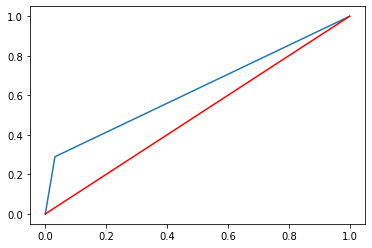

In [414]:
fpr,tpr,thresholds = roc_curve(data1.loc[test_indexes[9], 'target'], ((model.predict(sm.add_constant(data1.loc[test_indexes[9], predictors])))>0.5).astype(float))
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
print('AUC: {}'.format(metrics.roc_auc_score(data1.loc[test_indexes[9], 'target'], ((model.predict(sm.add_constant(data1.loc[test_indexes[9], predictors])))>0.5).astype(float))))

model = sm.Logit(data1.loc[train_indexes[9], 'target'], data1.loc[train_indexes[9], predictors]).fit()
confusion_matrix(data1.loc[test_indexes[9], 'target'], ((model.predict(data1.loc[test_indexes[9], predictors]))>0.5).astype(float))



### Only on the statistically significant predictors

In [415]:
Xt = data1[['city_development_index', 'relevent_experience', 'Full time course','>20y experience', 'experience', 'company_size', 'NGO', 'Pvt_Ltd', 'Funded_Startup', '>4y from last job','last_new_job']]
Xt = sm.add_constant(Xt)
yt = data1['target']
model2 = sm.Logit(yt, Xt).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.367115
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 9785
Model:                          Logit   Df Residuals:                     9773
Method:                           MLE   Df Model:                           11
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.1737
Time:                        14:55:12   Log-Likelihood:                -3592.2
converged:                       True   LL-Null:                       -4347.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.0842      0.220     23.105      0.000       4.653       5.516
city_development_index    -7.7377      0.241    -32.086      0.000      -8.210      -7.265
relevent_experience       -0.2184      0.088     -2.494      0.013      -0.390      -0.047
Full time course           0.1902      0.090      2.125      0.034       0.015       0.366
>20y experience           -0.7301      0.127     -5.747      0.000      -0.979      -0.481
experience                -0.0416      0.008     -5.420      0.000      -0.057      -0.027
company_size               0.0450      0.014      3.164      0.002       0.017       0.073
NGO                       -0.2701      0.178     -1.520      0.128      -0.618       0.078
Pvt_Ltd                   -0.2528      0.092     -2.734      0.006      -0.434      -0.072
Funded_Startup            -0.3038      0.140     -2.170      0.030      -0.578      -0.029
>4y from last job          0.2488      0.108      2.307      0.021       0.037       0.460
last_new_job               0.1159      0.034      3.424      0.001       0.050       0.182
==========================================================================================
"""

In [416]:
small_predictors = ['city_development_index',
 'relevent_experience',
 'Full time course',
 '>20y experience',
 'experience',
 'company_size',
 'Pvt_Ltd',
 'Funded_Startup',
 '>4y from last job',
 'last_new_job']

In [417]:
Accuracies = []
AUCs = []

for i in range(len(train_indexes)):
    #logreg.fit(data1.loc[train_indexes[i], predictors],data1.loc[train_indexes[i], 'target'])
    model = sm.Logit(data1.loc[train_indexes[i], 'target'], data1.loc[train_indexes[i], small_predictors]).fit()
    
    Accuracies.append(metrics.accuracy_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], small_predictors]) > 0.5).astype(int)))
    
    AUCs.append(metrics.roc_auc_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], small_predictors]) > 0.5).astype(int)))



Optimization terminated successfully.
         Current function value: 0.395019
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395776
  

In [418]:
print('Mean Accuracy Rate: {}\nMean Area under the ROC: {}'.format(np.mean(Accuracies), np.mean(AUCs)))

Mean Accuracy Rate: 0.8375060315709657
Mean Area under the ROC: 0.5042221469280834


AUC has become like no-skill classifier and still some coefficients have newly become statistically unsignificant.

### Some other predictors have lost siginificante, try again

In [474]:
smaller_predictors = ['city_development_index', 'relevent_experience', 'Full time course','>20y experience', 'experience', 'company_size', '>4y from last job','last_new_job']

In [475]:
Xt = data1[smaller_predictors]
Xt = sm.add_constant(Xt)
yt = data1['target']
model = sm.Logit(yt, Xt).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.367526
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 9785
Model:                          Logit   Df Residuals:                     9776
Method:                           MLE   Df Model:                            8
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.1728
Time:                        16:32:35   Log-Likelihood:                -3596.2
converged:                       True   LL-Null:                       -4347.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.8766      0.207     23.570      0.000       4.471       5.282
city_development_index    -7.7115      0.240    -32.089      0.000      -8.183      -7.241
relevent_experience       -0.2473      0.086     -2.860      0.004      -0.417      -0.078
Full time course           0.2032      0.089      2.274      0.023       0.028       0.378
>20y experience           -0.7337      0.127     -5.783      0.000      -0.982      -0.485
experience                -0.0420      0.008     -5.480      0.000      -0.057      -0.027
company_size               0.0419      0.014      3.022      0.003       0.015       0.069
>4y from last job          0.2465      0.107      2.298      0.022       0.036       0.457
last_new_job               0.1144      0.034      3.384      0.001       0.048       0.181
==========================================================================================
"""

In [421]:
Accuracies = []
AUCs = []

for i in range(len(train_indexes)):
    #logreg.fit(data1.loc[train_indexes[i], predictors],data1.loc[train_indexes[i], 'target'])
    model = sm.Logit(data1.loc[train_indexes[i], 'target'], data1.loc[train_indexes[i], smaller_predictors]).fit()
    
    Accuracies.append(metrics.accuracy_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], smaller_predictors]) > 0.5).astype(int)))
    
    AUCs.append(metrics.roc_auc_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict(data1.loc[test_indexes[i], smaller_predictors]) > 0.5).astype(int)))


Optimization terminated successfully.
         Current function value: 0.395958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396806
  

In [422]:
print('Mean Accuracy Rate: {}\nMean AUC: {}'.format(np.mean(Accuracies), np.mean(FS)))

Mean Accuracy Rate: 0.8370970336159556
Mean Precision Recall F-Score: 0.5029642852928633


In [423]:
model = sm.Logit(data1.loc[train_indexes[9], 'target'], data1.loc[train_indexes[9], smaller_predictors]).fit()
confusion_matrix(data1.loc[test_indexes[9], 'target'], ((model.predict(data1.loc[test_indexes[9], smaller_predictors]))>0.5).astype(float))


Optimization terminated successfully.
         Current function value: 0.396806
         Iterations 6


array([[818,   1],
       [158,   1]])

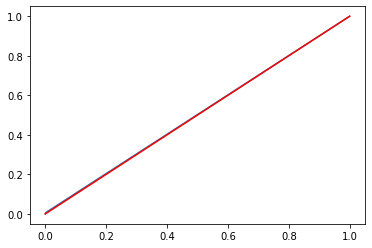

In [424]:
fpr,tpr,thresholds = roc_curve(data1.loc[test_indexes[9], 'target'], ((model.predict(data1.loc[test_indexes[9], smaller_predictors]))>0.5).astype(float))
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')

After removing all variables as they lost significance, we are left with a logistic regression on 8 variables:
- city_development_index
- elevent_experience
- Full time course
- \>20y experience
- experience
- company_size
- \>4y from last job
- last_new_job

We've lost a little bit on accuracy and the model is now not better than a no-skill classifier. This is due to the heavy imbalance on the target variable. By removing the predictors that were not statstically significant the model classifies most of the observations to 0 instead of 1. Most of the observations of class 1 are now false negatives, but because they are so few the Accuracy is barely impacted.

We can also see that negative coefficients have generally a greater magnitude than positive ones, so that makes the majority of predictions go to 0 when we reduce the number of predictors. City development index is the one that stands out in this aspect, and because its values are mostly close to one (the company looks mostly in cities with high development) the majority of the dataset bbelong to the class 0.

In [425]:
data1.city_development_index.describe()

count    9785.000000
mean        0.846043
std         0.114736
min         0.448000
25%         0.802000
50%         0.910000
75%         0.920000
max         0.949000
Name: city_development_index, dtype: float64

We can see that the minimum is relatively ihgh, 0.44, and both the mean and median are very close to 1, 0.84 and 0.91, respectively. This allows us to reach the first conclusion that highly-developed cities are a bad place to look for new employees, perhaps because of a relatively more competitive job market. We can also see thath the coefficients for experience and \>20y experience are negative, expecially the last one. Because of the values that the variable experience takes, the effect of the values on the higher end of this range will have a similar effect on the response as that of \>20y experience. This also shed light in that highly-experienced people don't generally join the company. Again this might be attributed to the competitiveness of the job market.

It could be that they stayed on their company, but the coefficients related to experience are positive, so it looks like people are looking for a job change the more they have been in their current one. Also the coefficient for Full time course is positive. This points out that potentially profiles of candidates to look at are:
- recent graduates and soon to be graduates
- People with a low to moderate amount of experience who have been in their jobs for some time (perhaps more than 2 years)

And the less economically developed the city they live in is, the higher chances they have to recruit them. These variables offer a possibility to do a rough classification. However, by removing variables from the beginning we lost the capacity to identify positives in the sample. A possible reason for this is that the company is mostly present in highly-developed cities and those of lower development are of no interest.

We'll try LDA and QDA classification next to see if we get better results.

# LDA Classification

In [426]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [427]:
from sklearn.metrics import confusion_matrix

In [433]:
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)

In [434]:
Accuracies = []
AUCs = []

for i in range(len(train_indexes)):
    #logreg.fit(data1.loc[train_indexes[i], predictors],data1.loc[train_indexes[i], 'target'])
    model = clf.fit(data1.loc[train_indexes[i], predictors].values, data1.loc[train_indexes[i], 'target'].values)
    
    Accuracies.append(metrics.accuracy_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict_proba(data1.loc[test_indexes[i], predictors]) > 0.5)[:,1].astype(int)))
    
    AUCs.append(metrics.roc_auc_score(data1.loc[test_indexes[i], 'target'],
                                            (model.predict_proba(data1.loc[test_indexes[i], predictors]) > 0.5)[:,1].astype(int)))


In [435]:
print(np.mean(Accuracies), np.mean(AUCs))

0.8571279069038772 0.7149273602956587


In [436]:
print('Split with most Accuracy: {}\nSplit with most AUC: {}'.format(Accuracies.index(max(Accuracies))+1, AUCs.index(max(AUCs))+1))

Split with most Accuracy: 4
Split with most AUC: 10


In [445]:
sorted(enumerate(Accuracies))

[(0, 0.86414708886619),
 (1, 0.8590398365679265),
 (2, 0.8529111338100103),
 (3, 0.8661899897854954),
 (4, 0.8467824310520939),
 (5, 0.852760736196319),
 (6, 0.8629856850715747),
 (7, 0.8496932515337423),
 (8, 0.8517382413087935),
 (9, 0.8650306748466258)]

In [446]:
sorted(enumerate(AUCs))

[(0, 0.700901211842307),
 (1, 0.7079920233164596),
 (2, 0.7058989621489622),
 (3, 0.7289224664224665),
 (4, 0.7097794566544566),
 (5, 0.7270947082267836),
 (6, 0.7255972538991408),
 (7, 0.7049899785748842),
 (8, 0.7062109797958854),
 (9, 0.7318865620752414)]

The best split is the 10th one, as it has almost the same accuracy as the 4th one and a higher AUC

In [448]:
model = clf.fit(data1.loc[train_indexes[9], predictors].values, data1.loc[train_indexes[9], 'target'].values)
confusion_matrix(data1.loc[test_indexes[9], 'target'], ((model.predict_proba(data1.loc[test_indexes[9], predictors]))>0.5)[:,1].astype(float))

array([[761,  58],
       [ 74,  85]])

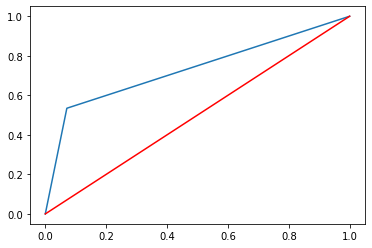

In [187]:
fpr,tpr,thresholds = roc_curve(data1.loc[test_indexes[9], 'target'], ((model.predict_proba(data1.loc[test_indexes[9], predictors]))>0.5)[:,1].astype(float))
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')

## Quadratic Discriminant analysis

In [449]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [450]:
qda = QuadraticDiscriminantAnalysis()


In [468]:
Accuracies = []
AUCs = []

for i in range(len(train_indexes)):
    #logreg.fit(data1.loc[train_indexes[i], predictors],data1.loc[train_indexes[i], 'target'])
    model = qda.fit(data1.loc[train_indexes[i], predictors].values, data1.loc[train_indexes[i], 'target'].values)
    
    Accuracies.append(metrics.accuracy_score(data1.loc[test_indexes[i], 'target'],
                                            (qda.predict_proba(data1.loc[test_indexes[i], predictors]) > 0.5)[:,1].astype(int)))
    
    AUCs.append(metrics.roc_auc_score(data1.loc[test_indexes[i], 'target'],
                                            (qda.predict_proba(data1.loc[test_indexes[i], predictors]) > 0.5)[:,1].astype(int)))


In [456]:
print(np.mean(Accuracies), np.mean(AUCs))

0.7641298558062879 0.6965539110599223


In [457]:
print('Split with most Accuracy: {}\nSplit with most AUC: {}'.format(Accuracies.index(max(Accuracies))+1, AUCs.index(max(AUCs))+1))

Split with most Accuracy: 4
Split with most AUC: 4


In [471]:
model = qda.fit(data1.loc[train_indexes[5], predictors].values, data1.loc[train_indexes[5], 'target'].values)
confusion_matrix(data1.loc[test_indexes[5], 'target'], ((model.predict_proba(data1.loc[test_indexes[5], predictors]))>0.5)[:,1].astype(float))

array([[650, 169],
       [ 57, 102]])

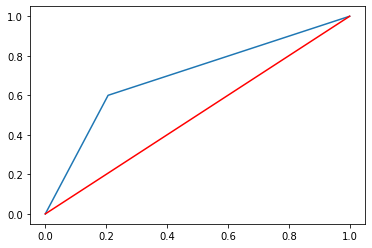

In [473]:
fpr,tpr,thresholds = roc_curve(data1.loc[test_indexes[4], 'target'], ((model.predict_proba(data1.loc[test_indexes[4], predictors]))>0.5)[:,1].astype(float))
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')

# Clustering

Following the classification step, a linear regression on the training hours was tried, to see if there was a possibility to identify people who spent more time on training and if it could be related to whether they joined the company. However, no conclusions could be drawn because the MSE was very high, so we opted for clustering instead to see if some more insight could be gained from the data.

In [834]:
lowest_bic = np.infty
# predictors

#Consider k=1,...,6 and four types of covariance matrix
n_components_range = range(1, 30)
cv_types = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(n_components_range),len(cv_types))) #matrix to store the BICs
j = -1
for cv_type in cv_types:
    j = j+1
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(data1)
        bicij = gmm.bic(data1)  #get the BIC 
        bic[n_components-1,j] = bicij
        #the code below keeps track of the model with the lowest BIC
        if bicij < lowest_bic:
            lowest_bic = bicij
            best_gmm = gmm
print(lowest_bic)
bic = pd.DataFrame(bic,columns = cv_types,index=n_components_range)
bic

-1301271.6390861394


,spherical,tied,diag,full
1,2.046549e+06,133769.994885,2.663854e+05,1.337700e+05
2,1.655396e+06,130629.945201,-9.338460e+04,-2.802874e+05
3,1.465570e+06,129398.718755,-3.559528e+05,-5.288107e+05
4,1.332770e+06,128750.963937,-6.486050e+05,-6.743593e+05
5,1.274490e+06,129090.278380,-6.769569e+05,-8.298465e+05
6,1.212616e+06,128701.049650,-5.183978e+05,-8.635060e+05
7,1.188678e+06,128858.779481,-8.718190e+05,-8.512590e+05
8,1.128396e+06,129012.404663,-8.120016e+05,-9.682667e+05
9,1.119283e+06,128842.696693,-8.778134e+05,-1.033172e+06
10,1.094920e+06,128930.718759,-9.588966e+05,-8.501201e+05


The lowest BIC is for the model with 28 clusters and a diagonal covariance matrix.

In [835]:
gmm = GaussianMixture(n_components=28, covariance_type='diag')
gmm.fit(data1)
labels = gmm.predict(data1)


Let's check the size of the clusters.

In [836]:
for i in range(1,27):
    print(data1.loc[labels == i, :].shape)

(780, 27)
(58, 27)
(63, 27)
(290, 27)
(155, 27)
(76, 27)
(14, 27)
(53, 27)
(29, 27)
(32, 27)
(55, 27)
(1172, 27)
(564, 27)
(286, 27)
(31, 27)
(25, 27)
(160, 27)
(2106, 27)
(116, 27)
(97, 27)
(22, 27)
(177, 27)
(2902, 27)
(76, 27)
(176, 27)
(157, 27)


Some of the clusters are really small, so we'll keep those with a size of at least 100 in a list to work only with those

In [ ]:
larger_clusters = []
for i in range(1,27):
    if data1.loc[labels == i, :].shape[0] > 99:
        larger_clusters.append(i)

In [837]:
larger_clusters

[1, 4, 5, 12, 13, 14, 17, 18, 19, 22, 23, 25, 26]

We'll keep only those clusters with a conversoin higher than the average to focus on the most relevant ones

In [598]:
data1['target'].sum()/len(data1['target'])

0.16280020439448134

In [857]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Here we print the variable summary for each of the relevant cluster used in the document to find important variables or comibnations of variables, and compare with the results around variable importance from the Logistic Regression.

In [858]:
for i in larger_clusters:
    if (data1.loc[labels == i, :].describe().iloc[1,26:27] > data1['target'].sum()/len(data1['target'])).bool():
        print('Cluster {}:\n{}'.format(i, data1.loc[labels == i, :].describe()))
        # .iloc[[0, 1, 2, 5],25:27]

Cluster 4:
       city_development_index  Female   Male  relevent_experience  \
count              290.000000   290.0  290.0           290.000000   
mean                 0.783638     0.0    1.0             0.872414   
std                  0.137184     0.0    0.0             0.334205   
min                  0.516000     0.0    1.0             0.000000   
25%                  0.624000     0.0    1.0             1.000000   
50%                  0.855000     0.0    1.0             1.000000   
75%                  0.920000     0.0    1.0             1.000000   
max                  0.939000     0.0    1.0             1.000000   

       Full time course  Part time course  High School    Graduate  \
count        290.000000        290.000000        290.0  290.000000   
mean           0.151724          0.117241          0.0    0.727586   
std            0.359373          0.322264          0.0    0.445971   
min            0.000000          0.000000          0.0    0.000000   
25%            0.

Cluster 18:
       city_development_index  Female    Male  relevent_experience  \
count             2106.000000  2106.0  2106.0          2106.000000   
mean                 0.761544     0.0     1.0             0.801519   
std                  0.137210     0.0     0.0             0.398951   
min                  0.448000     0.0     1.0             0.000000   
25%                  0.624000     0.0     1.0             1.000000   
50%                  0.762000     0.0     1.0             1.000000   
75%                  0.915000     0.0     1.0             1.000000   
max                  0.949000     0.0     1.0             1.000000   

       Full time course  Part time course  High School     Graduate  \
count       2106.000000        2106.00000       2106.0  2106.000000   
mean           0.264957           0.15812          0.0     0.773979   
std            0.441415           0.36494          0.0     0.418352   
min            0.000000           0.00000          0.0     0.000000   
25

Next we'll explore some combinations of variables commented on the paper as well, particularly those around women, people working in Early Stage Startups, and not having changed jobs in the previous 4 years.

In [891]:
print('Number of Females:', sum(data1.Female), 'Proportion:',sum(data1.Female)/len(data1.Female))

Number of Females: 831.0 Proportion: 0.08492590700051099


In [892]:
print('Number of Males:', sum(data1.Male), 'Proportion:',sum(data1.Male)/len(data1.Male))

Number of Males: 8857.0 Proportion: 0.9051609606540624


In [895]:
print('Females that converted:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Female'].values),
      '\nProportion over all Females:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Female'].values)/sum(data1.Female),
      '\nProportion over all Conversions:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Female'].values)/sum(data1['target'] == 1))

Females that converted: 137.0 
Proportion over all Females: 0.1648616125150421 
Proportion over all Conversions: 0.08600125549278091


In [897]:
print('Males that converted:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Male'].values),
      '\nProportion over all Males:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Male'].values)/sum(data1.Male),
      '\nProportion over all Conversions:', sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Male'].values)/sum(data1['target'] == 1))

#sum(data1.loc[data1.loc[data1['target'] == 1, :].index, 'Male'].values)

Males that converted: 1442.0 
Proportion over all Males: 0.16280907756576718 
Proportion over all Conversions: 0.9052102950408035


In [868]:
sum(data1['target'] == 1)

1593

In [898]:
print('Females in Early Stage Startups:', sum(data1.loc[data1.loc[data1['Female'] == 1, :].index, 'Early_Stage_Startup'].values))

Females in Early Stage Startups: 40.0


In [902]:
print('Females from Early Stage Startups that Converted: ', sum(data1.loc[data1.loc[data1['Female'] == 1, :].index.intersection(data1.loc[data1['Early_Stage_Startup'] == 1, :].index), 'target']))

Females from Early Stage Startups that Converted:  9.0


In [899]:
print('People in Early Stage Startups that converted:', sum(data1.loc[data1.loc[data1['Early_Stage_Startup'] == 1, :].index, 'target'].values))

People in Early Stage Startups that converted: 94.0


In [900]:
print('Males in Early Stage Startups:',sum(data1.loc[data1.loc[data1['Male'] == 1, :].index, 'Early_Stage_Startup'].values))

Males in Early Stage Startups: 387.0


In [904]:
print('Males from Early Stage Startups that Converted: ', sum(data1.loc[data1.loc[data1['Male'] == 1, :].index.intersection(data1.loc[data1['Early_Stage_Startup'] == 1, :].index), 'target']))

Males from Early Stage Startups that Converted:  85.0


There is no connection between early stage startups, <4y with the same employer and geneder in terms of conversion. Lets check the cluster's subset that converted.

In [915]:
data1.loc[data1.loc[labels == 25, :].index.intersection(data1.loc[data1['Female'] == 1, :].index), :].describe()

,city_development_index,Female,Male,relevent_experience,Full time course,Part time course,High School,Graduate,Masters,Phd,Other_major,Arts_major,Humanities_major,Business_Degree_major,STEM_major,>20y experience,experience,company_size,NGO,Public_Sector,Pvt_Ltd,Early_Stage_Startup,Funded_Startup,>4y from last job,last_new_job,training_hours,target
count,156.000000,156.0,156.0,156.000000,156.0,156.000000,156.0,156.000000,156.000000,156.0,156.0,156.0,156.0,156.0,156.0,156.0,156.000000,156.000000,156.0,156.0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.774788,1.0,0.0,0.737179,0.0,0.211538,0.0,0.750000,0.250000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.820513,3.141026,0.0,0.0,0.750000,0.153846,0.083333,0.179487,1.166667,55.987179,0.519231
std,0.133266,0.0,0.0,0.441583,0.0,0.409715,0.0,0.434407,0.434407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.361839,2.261740,0.0,0.0,0.434407,0.361963,0.277276,0.384996,1.002148,48.952642,0.501239
min,0.512000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,0.624000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.750000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.000000,1.000000,0.0,0.0,0.750000,0.000000,0.000000,0.000000,0.750000,22.000000,0.000000
50%,0.802000,1.0,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.000000,2.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,43.500000,1.000000
75%,0.920000,1.0,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.250000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.000000,5.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,2.000000,72.000000,1.000000
max,0.939000,1.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.000000,7.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,304.000000,1.000000


In [914]:
data1.loc[data1.loc[labels == 25, :].index.intersection(data1.loc[data1['target'] == 1, :].index), :].describe()

,city_development_index,Female,Male,relevent_experience,Full time course,Part time course,High School,Graduate,Masters,Phd,Other_major,Arts_major,Humanities_major,Business_Degree_major,STEM_major,>20y experience,experience,company_size,NGO,Public_Sector,Pvt_Ltd,Early_Stage_Startup,Funded_Startup,>4y from last job,last_new_job,training_hours,target
count,92.000000,92.000000,92.000000,92.000000,92.0,92.000000,92.0,92.00000,92.00000,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.000000,92.000000,92.0,92.0,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.0
mean,0.745554,0.880435,0.032609,0.793478,0.0,0.097826,0.0,0.76087,0.23913,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.521739,3.000000,0.0,0.0,0.793478,0.097826,0.076087,0.141304,1.195652,54.641304,1.0
std,0.143779,0.326230,0.178583,0.407027,0.0,0.298707,0.0,0.42889,0.42889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584921,2.243428,0.0,0.0,0.407027,0.298707,0.266590,0.350244,0.928654,47.559005,0.0
min,0.516000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0
25%,0.624000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,1.0
50%,0.624000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.000000,2.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,42.500000,1.0
75%,0.916250,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.250000,5.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,2.000000,68.250000,1.0
max,0.926000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.00000,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.000000,7.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,220.000000,1.0


In [916]:
data1.loc[data1.loc[labels == 25, :].index.intersection(data1.loc[data1['target'] == 1, :].index.intersection(data1.loc[data1['Female'] == 1, :].index)), :].describe()

,city_development_index,Female,Male,relevent_experience,Full time course,Part time course,High School,Graduate,Masters,Phd,Other_major,Arts_major,Humanities_major,Business_Degree_major,STEM_major,>20y experience,experience,company_size,NGO,Public_Sector,Pvt_Ltd,Early_Stage_Startup,Funded_Startup,>4y from last job,last_new_job,training_hours,target
count,81.000000,81.0,81.0,81.000000,81.0,81.000000,81.0,81.000000,81.000000,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.000000,81.000000,81.0,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,0.737716,1.0,0.0,0.814815,0.0,0.061728,0.0,0.740741,0.259259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.444444,3.123457,0.0,0.0,0.827160,0.074074,0.074074,0.123457,1.222222,55.530864,1.0
std,0.140802,0.0,0.0,0.390868,0.0,0.242161,0.0,0.440959,0.440959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.418710,2.238206,0.0,0.0,0.380464,0.263523,0.263523,0.331010,0.935414,49.124609,0.0
min,0.527000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0
25%,0.624000,1.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,1.0
50%,0.624000,1.0,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.000000,2.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,43.000000,1.0
75%,0.913000,1.0,0.0,1.000000,0.0,0.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.000000,5.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,2.000000,71.000000,1.0
max,0.926000,1.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.000000,7.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,220.000000,1.0


In [919]:
print('Proportion of people enrolled Full time:', sum(data1['Full time course'])/len(data1['Full time course']))

Proportion of people enrolled Full time: 0.10444557996934083


In [920]:
print('Proportion of people enrolled Part time:', sum(data1['Part time course'])/len(data1['Full time course']))

Proportion of people enrolled Part time: 0.06315789473684211
